In [3]:
import pandas as pd
import psycopg2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

dburl = ""

In [4]:
with psycopg2.connect(dburl, sslmode='require') as con:
    # Display the list of tables
    tables = pd.read_sql(
        "SELECT tablename FROM pg_catalog.pg_tables WHERE tablename LIKE 'app%';",
        con
    )
    display(tables['tablename'].tolist())

    # Read tables using SQL queries
    app_pslparam = pd.read_sql("SELECT * FROM app_pslparam;", con)
    app_subject = pd.read_sql("SELECT * FROM app_subject;", con)
    app_dataset = pd.read_sql("SELECT * FROM app_dataset;", con)
    app_experiment = pd.read_sql("SELECT * FROM app_experiment;", con)
    app_logentry = pd.read_sql("SELECT * FROM app_logentry;", con)

/tmp/ipykernel_180440/2837654521.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables = pd.read_sql(


['app_pslparam',
 'app_subject',
 'app_logentry',
 'app_dataset',
 'app_experiment']

/tmp/ipykernel_180440/2837654521.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_pslparam = pd.read_sql("SELECT * FROM app_pslparam;", con)
/tmp/ipykernel_180440/2837654521.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_subject = pd.read_sql("SELECT * FROM app_subject;", con)
/tmp/ipykernel_180440/2837654521.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_dataset = pd.read_sql("SELECT * FROM app_dataset;", con)
/tmp/ipykernel_180440/2837654521.py:13: UserWarning: pandas only supports SQLAlchemy c

In [5]:
app_logentry

,id,created_at,data,subject_id
0,1,2024-08-02 15:27:52.638586+00:00,"{'path': '/ex/q-SEhQ/', 'values': {}}",q-SEhQ
1,2,2024-08-02 15:28:05.274713+00:00,"{'path': '/ex/q-SEhQ/', 'values': {}}",q-SEhQ
2,3,2024-08-02 15:28:19.338187+00:00,"{'path': '/ex/OZMfzA/', 'values': {}}",OZMfzA
3,4,2024-08-02 15:31:39.701596+00:00,"{'path': '/ex/OZMfzA/', 'values': {}}",OZMfzA
4,5,2024-08-02 15:31:44.832422+00:00,"{'path': '/ex/OZMfzA/add', 'values': {}}",OZMfzA
...,...,...,...,...
1417,1336,2024-09-11 07:09:42.594973+00:00,"{'path': '/ex/VO7xXg/get', 'values': {}}",VO7xXg
1418,1337,2024-09-11 07:09:44.068323+00:00,"{'path': '/ex/VO7xXg/get', 'values': {}}",VO7xXg
1419,1338,2024-09-11 07:09:45.556584+00:00,"{'path': '/ex/VO7xXg/get', 'values': {}}",VO7xXg
1420,1520,2024-09-12 09:02:51.407959+00:00,"{'path': '/ex/7P-hCA/get', 'values': {}}",7P-hCA


In [6]:
# keep only study participants:
# ZligBg	8NEtzA	LN3JTA	Dlh1Ug	AX6jaw GGPALw	7P-hCA	
participant_pslvis_ids = ['ZligBg', '8NEtzA', 'LN3JTA', 'Dlh1Ug', 'AX6jaw', 'GGPALw', '7P-hCA']
app_logentry = app_logentry[app_logentry['subject_id'].isin(participant_pslvis_ids)]

In [7]:
# First, extract 'path' and 'values' from the 'data' column for easier access
app_logentry['path'] = app_logentry['data'].apply(lambda x: x.get('path', ''))
app_logentry['values'] = app_logentry['data'].apply(lambda x: x.get('values', {}))

# Create 'automatic_add' column
app_logentry['automatic_add'] = app_logentry['path'].str.contains("/add").astype(int)

# Create 'reset' column
app_logentry['reset'] = app_logentry['path'].str.contains("/reset").astype(int)

# Create 'moving' column
app_logentry['moving'] = app_logentry['values'].apply(lambda x: 1 if 'to' in x else 0)

# Create 'updating_score' column
app_logentry['updating_score'] = app_logentry['values'].apply(lambda x: 1 if x.get('type') == 'score' else 0)

# Create 'adding_feature' column
app_logentry['adding_feature'] = app_logentry.apply(
    lambda x: 1 if (x['values'].get('toList') == 'used') and (x['moving'] == 0) else 0,
    axis=1
)

# Create 'removing_feature' column
app_logentry['removing_feature'] = app_logentry.apply(
    lambda x: 1 if (x['values'].get('toList') == 'unused') and (x['moving'] == 0) else 0, axis=1
)

/tmp/ipykernel_180440/1043379488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_logentry['path'] = app_logentry['data'].apply(lambda x: x.get('path', ''))
/tmp/ipykernel_180440/1043379488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_logentry['values'] = app_logentry['data'].apply(lambda x: x.get('values', {}))
/tmp/ipykernel_180440/1043379488.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [8]:
# Define a function to determine the action(s)
def determine_action(row):
    actions = []
    if row['reset'] == 1:
        actions.append('reset')
    if row['automatic_add'] == 1:
        actions.append('automatic_add')
    if row['moving'] == 1:
        actions.append('moving')
    if row['updating_score'] == 1:
        actions.append('updating_score')
    if row['adding_feature'] == 1:
        actions.append('adding_feature')
    if row['removing_feature'] == 1:
        actions.append('removing_feature')
    return ', '.join(actions)

# Apply the function to each row to create the 'action' column
app_logentry['action'] = app_logentry.apply(determine_action, axis=1)

app_logentry['action'] = app_logentry['action'].replace('', np.nan)

/tmp/ipykernel_180440/4224595183.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_logentry['action'] = app_logentry.apply(determine_action, axis=1)
/tmp/ipykernel_180440/4224595183.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_logentry['action'] = app_logentry['action'].replace('', np.nan)


In [9]:
app_logentry['action'].value_counts()

action
updating_score      435
moving               62
adding_feature       55
removing_feature     33
automatic_add        32
reset                 5
Name: count, dtype: int64

In [10]:
# for subject_id == AX6jaw we need to remove all actions with ids between 1070 and 1090 because of a bug
app_logentry = app_logentry[~((app_logentry['subject_id'] == 'AX6jaw') & (app_logentry['id'] >= 1070) & (app_logentry['id'] <= 1090))]

In [11]:
app_logentry.to_clipboard()

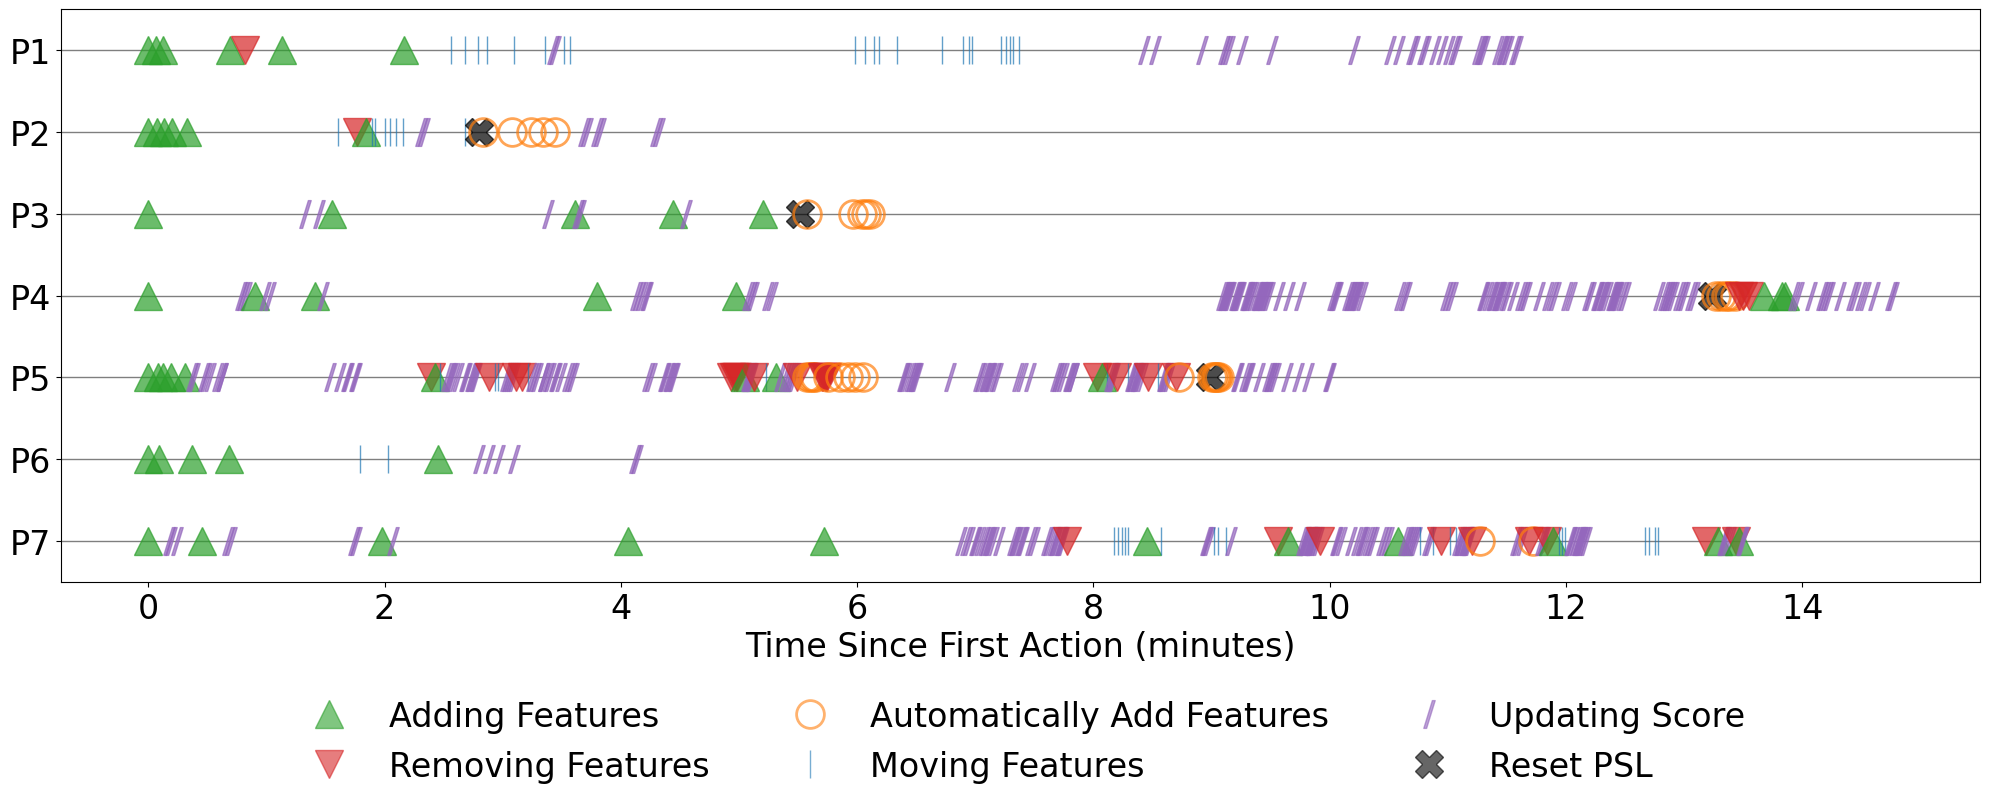

In [12]:
# Assuming 'app_logentry' DataFrame is already defined
filtered_df = app_logentry[app_logentry['action'].notna() & (app_logentry['action'] != '')].copy()

# Convert 'created_at' to datetime if it's not already
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])

# Sort the DataFrame by 'created_at'
filtered_df.sort_values(by='created_at', inplace=True)

# renaming subject_id: 
# ZligBg P1
# 8NEtzA P2
# LN3JTA P3
# Dlh1Ug P4
# AX6jaw P5
# GGPALw P6
# 7P-hCA P7

filtered_df['subject_id'] = filtered_df['subject_id'].replace({
    'ZligBg': 'P1',
    '8NEtzA': 'P2',
    'LN3JTA': 'P3',
    'Dlh1Ug': 'P4',
    'AX6jaw': 'P5',
    'GGPALw': 'P6',
    '7P-hCA': 'P7'
})

# sort by subject_id the new id and also by created_at
filtered_df = filtered_df.sort_values(by=['subject_id', 'id', 'created_at'], ascending=[False, True, True])

renaming_dict = {
    'adding_feature': 'Adding Features',
    'removing_feature': 'Removing Features',
    'moving': 'Moving Features',
    'updating_score': 'Updating Score',
    'automatic_add': 'Automatically Add Features',
    'reset': 'Reset PSL'
}

# Define specific action to color and marker mappings
action_styles = {
    'Adding Features': {'color': '#2ca02c', 'marker': '^'},    # Green triangle
    'Removing Features': {'color': '#d62728', 'marker': 'v'},  # Red upside-down triangle
    'Automatically Add Features': {'color': '#ff7f0e', 'marker': 'o'},  # Orange circle
    'Moving Features': {'color': '#1f77b4', 'marker': '|'},    # Teal square
    'Updating Score': {'color': '#9467bd', 'marker': '$/$'},     # Purple circle
    'Reset PSL': {'color': '#000', 'marker': 'X'},          # Brown square
}

filtered_df['action'] = filtered_df['action'].replace(renaming_dict)

# Filter the DataFrame to only include the specified actions
filtered_df = filtered_df[filtered_df['action'].isin(action_styles.keys())]

# Normalize the time stamps for each subject
# Calculate the time of the first action for each subject
first_action_times = filtered_df.groupby('subject_id')['created_at'].min().reset_index()
first_action_times.rename(columns={'created_at': 'first_action_time'}, inplace=True)

# Merge the first action times back into the filtered_df
filtered_df = filtered_df.merge(first_action_times, on='subject_id', how='left')

# Calculate the time difference from the first action
filtered_df['time_since_first_action'] = filtered_df['created_at'] - filtered_df['first_action_time']

# Convert time differences to total minutes
filtered_df['time_since_first_action_minutes'] = filtered_df['time_since_first_action'].dt.total_seconds() / 60

# Get the list of unique subjects and assign y-positions
subjects = filtered_df['subject_id'].unique()
subject_positions = {subject: idx for idx, subject in enumerate(subjects)}

# **Adjust the figure size to make the graph wider**
# Adjust the figure size to make the graph taller (more space between the lines)
fig, ax = plt.subplots(figsize=(20, len(subjects) * 1.2))  # Increased height from 0.6 to 1.2 per subject

# Plot horizontal lines for each subject's timeline
for subject, y_position in subject_positions.items():
    ax.axhline(y=y_position, color='black', linewidth=1, alpha=0.5)

# Plot each action as a point on the respective subject's timeline
for idx, row in filtered_df.iterrows():
    subject = row['subject_id']
    y_position = subject_positions[subject]
    action = row['action']
    time = row['time_since_first_action_minutes']
    style = action_styles[action]
    color = style['color']
    marker = style['marker']

    # Set markerfacecolor and markeredgecolor based on action
    if action == 'Automatically Add Features':
        markerfacecolor = 'none'       # No filling
        markeredgecolor = color        # Outline color
        markeredgewidth = 2            # Increase edge width for visibility
    else:
        markerfacecolor = color        # Filled with color
        markeredgecolor = color        # Edge color same as face color
        markeredgewidth = 1            # Default edge width

    # Plot the point with specified marker, color, size, and transparency
    ax.plot(
        time,
        y_position,
        marker=marker,
        markersize=20,
        linestyle='None',
        markerfacecolor=markerfacecolor,
        markeredgecolor=markeredgecolor,
        markeredgewidth=markeredgewidth,
        alpha=0.7
    )

# Set y-ticks to the subject positions and labels
ax.set_yticks(list(subject_positions.values()))
ax.set_yticklabels(list(subject_positions.keys()))

# Set x-axis label
ax.set_xlabel('Time Since First Action (minutes)', fontsize=24)

# Set y-axis label
ax.set_ylabel('', fontsize=16)

# Optional: Set limits for better spacing (adjust as needed)
ax.set_ylim(-0.5, len(subjects) - 0.5)

# Increase font size for ticks
ax.tick_params(axis='both', which='major', labelsize=24)

# Remove gridlines for clarity
ax.grid(False)

# **Move the legend to the bottom of the plot**
handles = []
for action in action_styles:
    marker = action_styles[action]['marker']
    color = action_styles[action]['color']

    if action == 'Automatically Add Features':
        markerfacecolor = 'none'       # No filling
        markeredgecolor = color        # Outline color
        markeredgewidth = 2            # Increase edge width for visibility
    else:
        markerfacecolor = color        # Filled with color
        markeredgecolor = color        # Edge color same as face color
        markeredgewidth = 1            # Default edge width

    handle = plt.Line2D(
        [0], [0],
        marker=marker,
        color='w',
        label=action,
        markerfacecolor=markerfacecolor,
        markeredgecolor=markeredgecolor,
        markeredgewidth=markeredgewidth,
        markersize=20,
        linestyle='None',
        alpha=0.6
    )
    handles.append(handle)

# Place the legend below the plot
ax.legend(
    handles=handles,
    bbox_to_anchor=(0.5, -0.10),
    loc='upper center',
    ncol=3,
    title=' ',
    frameon=False,
    fontsize=24
)

# Set title
# plt.title('Action Timelines', fontsize=24)

# Adjust layout to accommodate the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust bottom margin to prevent clipping of legend

plt.savefig('timelines.pdf', format='pdf')

plt.show()
